## Preparation

### Import Libraries

In [1]:
import faiss
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import pandas as pd
import pickle
from transformers import GPT2Tokenizer, GPT2LMHeadModel

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/Users/vickieduong/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


### Load trained faiss

In [2]:
with open('./faiss_index/para_trained_index.index', 'rb') as f:
  para_train_index = pickle.load(f)
  para_train_index = para_train_index.iloc[0]


with open('./faiss_index/sent_trained_index.index', 'rb') as f:
  sent_train_index = pickle.load(f)
  sent_train_index = sent_train_index.iloc[0]

with open('./faiss_index/titSec_trained_index.index', 'rb') as f:
  titSec_train_index = pd.read_pickle(f)
  titSec_train_index = titSec_train_index.iloc[0]

### Load dataset

In [119]:
para = pd.read_csv("./dataset/paragraph.csv")

sent = pd.read_csv("./dataset/sentence.csv")
titSec = pd.read_csv("./dataset/titSec.csv")
title = pd.read_csv("./dataset/title.csv")
section = pd.read_csv("./dataset/section.csv")

### Text Embedding Function

In [4]:
model_name = "bert" # or "bert"
if model_name == 'bert':
  # Load the model and tokenizer
  model_name = "bert-base-uncased"
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model_path =  "/content/drive/MyDrive/CS5830/bert_plato/bert_finetuned"
  model = AutoModel.from_pretrained(model_name).to(device)

  def get_embedding(sentence):
	  inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
	  inputs = inputs.to(device)
	  output = model(**inputs)
	  embedding = output.last_hidden_state.mean(dim=1).detach().cpu().numpy()
	  return embedding



/Users/vickieduong/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [5]:
philosophical_ideas = [
	"The nature of reality and perception in Plato's allegory of the cave.",
	"Existentialism and the search for meaning according to Sartre.",
	"The concept of 'Übermensch' in Nietzsche's philosophy.",
	"Kant's categorical imperative and moral law.",
	"The influence of Confucianism on Eastern thought and society.",
	"Simone de Beauvoir and the ethics of ambiguity.",
	"The idea of justice in Rawls' theory of justice.",
	"The problem of evil",
	"Descartes' cogito ergo sum and the quest for certainty.",
	"The social contract according to Rousseau."
]


In [6]:

sentence = "Much of the philosophical work on self-consciousness concerns its relation to a variety of other phenomena. These include the nature of personhood, rationality, consciousness, and the awareness of other minds. In each case we can ask whether self-consciousness is a necessary and/or sufficient condition for the phenomenon in question."
sentence = 'Virtue ethics is one of the main way to morality'
sentence = 'the properties of God are omnipotent, omnipresent, and omnibenevolent'
sentence = philosophical_ideas[0]

# sort paragraph on similarity using finetuned bert

In [7]:
from transformers import BertForMaskedLM
model_path = "checkpoint-4000"
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
fmodel = BertForMaskedLM.from_pretrained(model_path)
fmodel = fmodel.bert
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
fmodel = fmodel.to(device)

model = AutoModel.from_pretrained(model_name).to(device)
def get_embedding(sentence):
  inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
  inputs = inputs.to(device)
  output = model(**inputs)
  embedding = output.last_hidden_state.mean(dim=1).detach().cpu().numpy()
  return embedding

def get_embedding_finetuned(sentence):
  inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
  inputs = inputs.to(device)
  output = fmodel(**inputs)
  embedding = output.last_hidden_state.mean(dim=1).detach().cpu().numpy()
  return embedding


def calculate_similarity(embedding1, embedding2):
  return np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))

#print(calculate_similarity(reference_embedding, example_embedding))

In [8]:
philosophical_statements = [
	"The essence of human freedom lies in the ability to choose, even in the face of existential constraints, as proposed by Jean-Paul Sartre, emphasizing the responsibility that comes with such freedom.",
	"Immanuel Kant posited that moral actions are those performed out of duty, guided by the categorical imperative, which acts as a universal maxim for ethical behavior irrespective of personal desires.",
	"Aristotle argued that the goal of human life is to achieve eudaimonia, or flourishing, through the practice of virtue and rational living, suggesting a harmonious balance between pleasure and moral duty.",
	"Plato's theory of forms suggests that the material world is a shadow of the true reality, the world of forms, where each material object is an imperfect reflection of its perfect form.",
	"Ludwig Wittgenstein contended that the limits of my language mean the limits of my world, indicating that our understanding and knowledge of the world are intrinsically linked to the language we use to describe it."
]


In [9]:

reference_sentence  = 'the properties of God are omnipotent, omnipresent, and omnibenevolent'
reference_sentence = "freewill"
print(reference_sentence)
reference_embedding = get_embedding(reference_sentence)




freewill


### sort the result in sentences

In [10]:
# sentence
# search similarity
result = sent_train_index.search(reference_embedding, 200)
reference_embedding_squeeze = reference_embedding.squeeze()
result_texts = [sent.loc[i]['sentence'] for i in result[1][0]]
result_embedding = [get_embedding(t).squeeze() for t in result_texts]
result_similarity = [calculate_similarity(reference_embedding_squeeze, e) for e in result_embedding]

# sort result_texts using result_similairty
sent_result_df = sent.loc[result[1][0]]
sent_result_df['similarity'] = result_similarity
sent_result_df = sent_result_df.sort_values('similarity', ascending=False)

# merge with para
sent_result_df = pd.merge(sent_result_df, para[['paragraph_id', 'paragraph','title_id', 'section_id',]], on='paragraph_id')
sent_result_df = sent_result_df[['title_id', 'section_id', 'paragraph_id', 'sentence_id', 'sentence', 'paragraph', 'similarity']]

#merge with seciton

sent_result_df = pd.merge(sent_result_df, section[['section_id', 'title_id', 'section']], on=['title_id', 'section_id'])
sent_result_df = sent_result_df[['title_id', 'section_id', 'section', 'paragraph_id', 'sentence_id', 'sentence', 'paragraph', 'similarity']]

# merge with title
title.rename(columns={'id': 'title_id'}, inplace=True)
sent_result_df = pd.merge(sent_result_df, title[['title_id', 'title']], on='title_id')
sent_result_df = sent_result_df[['title_id', 'title', 'section_id', 'section', 'paragraph_id', 'sentence_id', 'sentence', 'paragraph', 'similarity']]

sent_result_df['titSec'] = sent_result_df['title'] + ' ' + sent_result_df['section']
sent_result_df

,title_id,title,section_id,section,paragraph_id,sentence_id,sentence,paragraph,similarity,titSec
0,tt000158,Edmund Burke,sc000796,6. Burke’s practical reasoning,pa005570,se019330,"who born for the universe, narrow’d his mind, and to party gave up, what was meant for mankind.","Who born for the Universe, narrow’d his mind,\n\n And to party gave up, what was meant for mankind.\n\n Tho’ fraught with all learning, kept straining his throat,\n\n To persuade Tommy Townshend to lend him a vote.\n\n (Goldsmith, lines 31–34).",0.552638,Edmund Burke 6. Burke’s practical reasoning
1,tt000158,Edmund Burke,sc000794,4. Philosophical and Historical Writings,pa005552,se019235,"it was they who had the power to guide people to the proper ends, or elsewhere.","\n\nThis understanding of the mind gave speakers and writers an\nunusually powerful role. It was in their hands to connect words which\nsuggested pro-attitudes with arrangements of their choosing:\nfor these words had did not imply only one set of conceptual contents,\nbecause they implied none. If one recollects the propensity to\nimitation that Burke found in mankind, this choosing was likely also to\nbe leading. So Burke was exceptionally sensitive to the role of men of\nletters and public speakers in moulding opinion. By the same measure,\nhe had an unusually lively sense of their responsibilities. It was\nthey who had the power to guide people to the proper ends, or\nelsewhere. Guidance need not be directly didactic—indeed, it\ncould not be, because there could be no definitions to expound —\nbut would be a matter of providing a linguistic context which guided\nlisteners and readers to goals that were ethically and politically\nbeneficial.",0.485530,Edmund Burke 4. Philosophical and Historical Writings
2,tt001441,Logic and Games,sc006916,"8. Games of dialogue, communication and proof",pa049492,se164976,in particular it was open to a teacher of obligationes to discover new rules.,"\nSeveral medieval texts describe a form of debate called\nobligationes. There were two disputants, Opponens and\nRespondens. At the beginning of a session, the disputants would agree\non a ‘positum’, typically a false statement. The job of\nRespondens was to give rational answers to questions from Opponens,\nassuming the truth of the positum; above all he had to avoid\ncontradicting himself unnecessarily. The job of Opponens was to try to\nforce Respondens into contradictions. So we broadly know the answer to\nthe Dawkins question, but we don’t know the game rules! The\nmedieval textbooks do describe several rules that the disputants\nshould follow. But these rules are not stipulated rules of the game;\nthey are guidelines which the textbooks derive from principles of\nsound reasoning with the aid of examples. (Paul of Venice justifies\none rule by the practice of ‘great logicians, philosophers,\ngeometers and theologians’.) In particular it was open to a\nteacher of obligationes to discover new rules. This open-endedness\nimplies that obligationes are not logical games in our sense.",0.548982,"Logic and Games 8. Games of dialogue, communication and proof"
3,tt000798,Nothingness,sc003904,4. The restriction to concrete entities,pa027529,se093212,the enemies of holes speak from a higher link in the chain of being.,"\nOntological pluralists do not dismiss this proof as sophistry. Kris\nMcDaniel (2013, 277) thinks the proof is trivially correct. To address\na more interesting question, McDaniel follows Aristotle’s\nprinciple that there are many ways of being. From the\npluralist’s perspective, debate over whether holes exist is\nequivocal. The friends of absences use a broad sense of\n‘being’. The enemies of holes speak from a higher link in\nthe chain of being. From this altitude, holes depend on their hosts\nand so cannot be as real. Alexius Meinong’s talk of subsistence\nalludes to the lowest level of being. “Why does anything\nsubsist?” is a perfectly legitimate question, according to\nMcDaniel.",0.541247,No

### sort the result in paragraphs


In [11]:
# paragraphd
# search similarity
result = para_train_index.search(reference_embedding, 50)
reference_embedding_squeeze = reference_embedding.squeeze()
result_texts = [para.loc[i]['paragraph'] for i in result[1][0]]
result_embedding = [get_embedding(t).squeeze() for t in result_texts]
result_similarity = [calculate_similarity(reference_embedding_squeeze, e) for e in result_embedding]

# sort result_texts using result_similairty
para_result_df = para.loc[result[1][0]]
para_result_df['similarity'] = result_similarity
para_result_df = para_result_df.sort_values('similarity', ascending=False)

# merge with title
para_result_df = pd.merge(para_result_df, title[['title_id', 'title']], on='title_id')
para_result_df = para_result_df[['title_id','section_id', 'paragraph_id', 'title', 'section', 'paragraph', 'similarity']]

In [12]:
para_result_df

,title_id,section_id,paragraph_id,title,section,paragraph,similarity
0,tt000395,sc001936,pa013177,African Ethics,6. Humanity and Brotherhood,\nThe human being is more beautiful than gold.\n(onipa ye fe sen sika),0.490647
1,tt001719,sc008350,pa059767,Supertasks,1. Mechanical properties,\nStrange things can happen when one carries out an infinite task.,0.489187
2,tt001068,sc000033,pa036876,The Traditional Square of Opposition,1. Introduction,[SQUARE] =df SQUARE + “the E and I forms convert\nsimply”,0.477214
3,tt001068,sc005170,pa036886,The Traditional Square of Opposition,3. The (Ir)relevance of Syllogistic,"\nNo C is B \nEvery A is C \nSo, some A is not B\n",0.408264
4,tt001068,sc005170,pa036884,The Traditional Square of Opposition,3. The (Ir)relevance of Syllogistic,"\nEvery C is B \nEvery C is A \nSo, some A is B\n",0.367762
5,tt000675,sc003283,pa023133,Salomon Maimon,1. Intellectual Biography,\n“Scholars of Wisdom have no rest in this world or in the\nworld to come.”,0.468705
6,tt000176,sc000876,pa006194,Margaret Lucas Cavendish,9. Fancies,\n3. Gentleman. Why may not a Lady write a good Play?\n,0.467248
7,tt001547,sc007462,pa053515,Ancient Logic,7. Later Antiquity,\n From ‘A holds of no B’ infer\n‘A does not hold of some B’\n,0.466173
8,tt001547,sc007462,pa053514,Ancient Logic,7. Later Antiquity,\n From ‘A holds of every B’ infer\n‘A holds of some B’\n,0.448158
9,tt001564,sc007540,pa054094,The Logic of Mass Expressions,7. Logical relations,"\nThis is gold. All gold is metal. Therefore, this is\nmetal.",0.465063


### Find similar title_sec

In [13]:
# search for title_sec similarity
result  = titSec_train_index.search(reference_embedding, 10)
reference_embedding_squeeze = reference_embedding.squeeze()
result_texts = [titSec.loc[i]['titSec'] for i in result[1][0]]
result_embedding = [get_embedding(t).squeeze() for t in result_texts]
result_similarity = [calculate_similarity(reference_embedding_squeeze, e) for e in result_embedding]

# sort
titSec_result_df = titSec.loc[result[1][0]]
titSec_result_df['similarity'] = result_similarity
titSec_result_df = titSec_result_df.sort_values('similarity', ascending=False)
titSec_result_df

,id,section_id,title,section,titSec,similarity
45,tt000008,sc000045,Action,3. Extended Action,Action 3. Extended Action,0.607818
7397,tt001357,sc006531,Divine Simplicity,1. Motivation,Divine Simplicity 1. Motivation,0.589074
1474,tt000266,sc001338,Corruption,3. Noble Cause Corruption,Corruption 3. Noble Cause Corruption,0.577500
2437,tt000448,sc002192,Free Will,3. Do We Have Free Will?,Free Will 3. Do We Have Free Will?,0.564155
4994,tt000910,sc004463,Divine Providence,2. The Free Will Defense,Divine Providence 2. The Free Will Defense,0.557740
6107,tt001124,sc005405,Trust,4. Trust and the Will,Trust 4. Trust and the Will,0.556633
8455,tt001557,sc001633,Free Logic,3. Semantics,Free Logic 3. Semantics,0.553848
4807,tt000880,sc004286,Preferences,2. Preference logic,Preferences 2. Preference logic,0.541880
4534,tt000830,sc004050,Blaise Pascal,3. Free Will,Blaise Pascal 3. Free Will,0.527412
8380,tt001542,sc007423,Locke On Freedom,5. Free Will,Locke On Freedom 5. Free Will,0.509600


In [14]:
print(reference_sentence)

freewill


In [15]:
compareDf = None
compareDf = sent_result_df['sentence']
finetunedEmbedding = get_embedding_finetuned(reference_sentence).squeeze()
sim = compareDf.map(lambda x: calculate_similarity(finetunedEmbedding, get_embedding_finetuned(x).squeeze()))

compareDf = pd.DataFrame(compareDf)
compareDf['similarity'] = sim
compareDf = compareDf.sort_values('similarity', ascending=False)


compareDf.columns = ['finetuned_sentence', 'finetuned_similarity']
compareDf['original_similarity'] = sent_result_df['similarity']
compareDf['original_index'] = compareDf.index
compareDf.reset_index(drop=True, inplace=True)
compareDf['current_index'] = compareDf.index
compareDf


,finetuned_sentence,finetuned_similarity,original_similarity,original_index,current_index
0,"incomplete properties); belief is set over what is f and not-f, the material particulars.",0.575822,0.522493,18,0
1,"the latter would be reason without an opposite, a free-floating power without definite shape.",0.565495,0.501927,52,1
2,some property of the individuals being chosen between) has no influence.,0.558306,0.492490,80,2
3,god did not establish to elicit effects absolutely by his mere act of free will.,0.550769,0.483452,95,3
4,quine's beginning to worship must occur too if this one does.,0.549834,0.500426,54,4
5,in particular it was open to a teacher of obligationes to discover new rules.,0.547579,0.548982,2,5
6,but when exactly twelve others vote it benefits i to vote.,0.545007,0.517467,24,6
7,strength of will is probably a formal relation one has to oneself.,0.539176,0.496991,75,7
8,"who born for the universe, narrow’d his mind, and to party gave up, what was meant for mankind.",0.538442,0.552638,0,8
9,doing what one says one must not do) than it is to do this with “ought”.,0.536007,0.479972,102,9


#### movement analysis

In [16]:
#Calculating movement
compareDf['movement'] = (compareDf['original_index'] - compareDf['current_index']).abs()

# Calculating total, average, and maximum movement
total_movement = compareDf['movement'].sum()
average_movement = compareDf['movement'].mean()
max_movement = compareDf['movement'].max()

print(f"Total Movement: {total_movement}")
print(f"Average Movement: {average_movement}")
print(f"Maximum Movement: {max_movement}")

Total Movement: 10606
Average Movement: 53.03
Maximum Movement: 154


<Axes: >

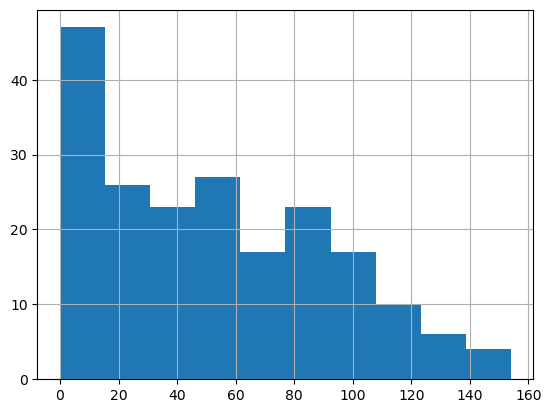

In [17]:
compareDf['movement'].hist()

#### Kendalltau test

low p-value mean it is statistically significant that there is difference between the orignal index and current index. In other words, there is difference in the similarity between using bert-uncase and using bert model finetuned on the dataset.

In [18]:
from scipy.stats import kendalltau

tau, p_value = kendalltau(compareDf['original_index'], compareDf['current_index'])

print(f"Kendall Tau: {tau}")
print(f"P-value: {p_value}")

Kendall Tau: 0.2387939698492462
P-value: 5.123811957298219e-07


### Test search when the query is short

In [19]:
reference_embedding = get_embedding("problem of evil")

In [93]:
titsec_result = titSec_train_index.search(reference_embedding, 200)
titsec_result_df = titSec.loc[titsec_result[1][0]]
titsec_result_df['similarity'] = titsec_result_df['titSec'].map(lambda x: calculate_similarity(reference_embedding, get_embedding_finetuned(x).squeeze())[0])
titsec_result_df = titsec_result_df.sort_values('similarity', ascending=False)
titsec_result_df

,id,section_id,title,section,titSec,similarity
7598,tt001393,sc006712,The Problem of Evil,6. Attempted Defenses,The Problem of Evil 6. Attempted Defenses,0.690339
7588,tt001391,sc006702,The Concept of Evil,5. Evil Institutions,The Concept of Evil 5. Evil Institutions,0.687846
1354,tt000245,sc001227,Consciousness,3. Problems of Consciousness,Consciousness 3. Problems of Consciousness,0.682254
3484,tt000642,sc000070,Philosophy of Liberation,1. History,Philosophy of Liberation 1. History,0.676144
7599,tt001393,sc006713,The Problem of Evil,7. Theodicies,The Problem of Evil 7. Theodicies,0.672576
6434,tt001192,sc000889,The Logic of Action,Conclusion,The Logic of Action Conclusion,0.669856
7586,tt001391,sc006700,The Concept of Evil,3. Contemporary Theories of Evil Action,The Concept of Evil 3. Contemporary Theories of Evil Action,0.669436
8906,tt001638,sc000319,The Problem of Perception,4. Conclusion,The Problem of Perception 4. Conclusion,0.667446
46,tt000008,sc000046,Action,4. Practical Knowledge,Action 4. Practical Knowledge,0.664892
6202,tt001146,sc005490,Value Theory,1. Basic Questions,Value Theory 1. Basic Questions,0.661821


# tfidf

In [55]:
# perform tfidf on sent['sentence']

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(titSec['titSec'])




In [117]:
"""### sort the result in sentences"""
def searchBySentence(sentence, num_results=10):
	reference_embedding = get_embedding_finetuned(sentence)

	# sentence
	# search similarity
	result = sent_train_index.search(reference_embedding, num_results)
	reference_embedding_squeeze = reference_embedding.squeeze()
	result_texts = [sent.loc[i]['sentence'] for i in result[1][0]]
	result_embedding = [get_embedding_finetuned(t).squeeze() for t in result_texts]
	result_similarity = [calculate_similarity(reference_embedding_squeeze, e) for e in result_embedding]

	# sort result_texts using result_similairty
	sent_result_df = sent.loc[result[1][0]]
	sent_result_df['similarity'] = result_similarity
	sent_result_df = sent_result_df.sort_values('similarity', ascending=False)

	# merge with para
	sent_result_df = pd.merge(sent_result_df, para[['paragraph_id', 'paragraph','title_id', 'section_id',]], on='paragraph_id')
	sent_result_df = sent_result_df[['title_id', 'section_id', 'paragraph_id', 'sentence_id', 'sentence', 'paragraph', 'similarity']]

	#merge with seciton

	sent_result_df = pd.merge(sent_result_df, section[['section_id', 'title_id', 'section']], on=['title_id', 'section_id'])
	sent_result_df = sent_result_df[['title_id', 'section_id', 'section', 'paragraph_id', 'sentence_id', 'sentence', 'paragraph', 'similarity']]

	# merge with title
	title.rename(columns={'id': 'title_id'}, inplace=True)
	sent_result_df = pd.merge(sent_result_df, title[['title_id', 'title', 'url']], on='title_id')
	sent_result_df = sent_result_df[['title_id', 'title', 'section_id', 'section', 'paragraph_id', 'sentence_id', 'sentence', 'paragraph', 'similarity', 'url']]

	sent_result_df['titSec'] = sent_result_df['title'] + ' ' + sent_result_df['section']
	return sent_result_df


def searchBySentence1(sentence, num_results=10):
	result = sent_train_index.search(reference_embedding, num_results)
	reference_embedding_squeeze = reference_embedding.squeeze()

	result_texts = sent.loc[result[1][0]]['sentence']

	result_embedding = result_texts.map(lambda x: get_embedding(x).squeeze())
	result_similarity = result_embedding.map(lambda x: calculate_similarity(reference_embedding_squeeze, x))

	# sort result_texts using result_similairty
	sent_result_df = sent.loc[result[1][0]]
	sent_result_df['similarity'] = result_similarity
	sent_result_df = sent_result_df.sort_values('similarity', ascending=False)

	#sent_result_df = sent.loc[result[1][0]]
	# merge with para
	sent_result_df = pd.merge(sent_result_df, para[['paragraph_id', 'paragraph','title_id', 'section_id',]], on='paragraph_id')
	sent_result_df = sent_result_df[['title_id', 'section_id', 'paragraph_id', 'sentence_id', 'sentence', 'paragraph', 'similarity']]

	#merge with seciton

	sent_result_df = pd.merge(sent_result_df, section[['section_id', 'title_id', 'section']], on=['title_id', 'section_id'])
	sent_result_df = sent_result_df[['title_id', 'section_id', 'section', 'paragraph_id', 'sentence_id', 'sentence', 'paragraph', 'similarity']]

	# merge with title
	title.rename(columns={'id': 'title_id'}, inplace=True)
	sent_result_df = pd.merge(sent_result_df, title[['title_id', 'title', 'url']], on='title_id')
	sent_result_df = sent_result_df[['title_id', 'title', 'section_id', 'section', 'paragraph_id', 'sentence_id', 'sentence', 'paragraph', 'similarity', 'url']]

	sent_result_df['titSec'] = sent_result_df['title'] + ' ' + sent_result_df['section']
	return sent_result_df

In [118]:
# use a example reference to search for one sentence

reference_sentence = "Virtue Ethics is one of the main ways to morality"
result_df = searchBySentence1(reference_sentence, 200)
result_df['titSec'] = result_df['title'] + ' ' + result_df['section']

In [114]:
ref_emb = tfidf_vectorizer.transform([reference_sentence])

tfidf_embedding = tfidf_matrix.dot(ref_emb.T).toarray().flatten()
tfidf_para_zip = list(zip(titSec['id'],titSec['section_id'], tfidf_embedding))

tfidf_para_df = pd.DataFrame(tfidf_para_zip, columns=['title_id', 'section_id', 'tfidf_similarity'])
result_df = pd.merge(result_df, tfidf_para_df, on=['title_id', 'section_id'])
result_df['tot_similarity'] = result_df['similarity']*.6 + result_df['tfidf_similarity']*.4

In [115]:
result_df.sort_values('tot_similarity', ascending=False)


,title_id,title,section_id,section,paragraph_id,sentence_id,sentence,paragraph,similarity,url,titSec,tfidf_similarity,tot_similarity
23,tt000124,Henri Bergson,sc000631,6. The two sources of morality and religion,pa004364,se015371,the force of these needs is the source of the closed morality.,"\nThere is the closed morality, whose religion is static, and there is\nthe open morality, whose religion is dynamic. Closed morality and\nstatic religion are concerned with social cohesion. Nature has made\ncertain species evolve in such a way that the individuals in these\nspecies cannot exist on their own. They are fragile and require the\nsupport of a community. One quickly thinks of bees, and Bergson, of\ncourse, refers to them. We can see again that there are bodily needs\nwhich must be satisfied. The force of these needs is the source of the\nclosed morality. Because of these needs, there is a rigidity to the\nrules of closed moralities. Kant’s moral philosophy has its\nsource in such needs. The survival of the community requires that\nthere be strict obedience: the categorical imperative. Yet, although\nKant’s categorical imperative is supposed to be universal, it is\nnot, according to Bergson. It is limited and particular. Closed\nmorality really concerns the survival of a society, my society.\nTherefore, it always excludes other societies. Indeed, for Bergson,\nclosed morality is always concerned with war. And static religion, the\nreligion of closed morality, is based on what Bergson calls the\n“fabulation function.” The fabulation function is a\nparticular function of the imagination that creates “voluntary\nhallucinations.” The fabulation function takes our sense that\nthere is a presence watching over us and invents images of gods. These\nimages then insure strict obedience to the closed morality. In short,\nthey insure social cohesion.",0.628166,https://plato.stanford.edu/entries/bergson,Henri Bergson 6. The two sources of morality and religion,0.152151,0.437760
132,tt001333,Descartes’ Ethics,sc006424,4. Virtue and Happiness: The Correspondence with Princess Elisabeth,pa045948,se152746,reason shows that the greatest good within our power is the perfection of the will.,"\nBut how exactly does reason allow us to discriminate between lesser\nand greater goods? On one point Descartes’ position is clear:\nthe claim of virtue to be the supreme good follows from the fact that\nit is nothing more than the correct use of our free will, employing it\nto choose whatever reason represents as the greatest good. As\nDescartes argues in the Fourth Meditation, we are in no way more like\nGod—that is, more perfect—than in our possession of free\nwill. Hence the correct use of this will is our greatest good:\n“free will is in itself the noblest thing we can have, since it\nmakes us in a way equal to God and seems to exempt us from being his\nsubjects; and so its correct use is the greatest of all the goods we\npossess” (AT V 85/CSMK 326). Reason shows that the greatest good\nwithin our power is the perfection of the will. In any choice we make,\nthe value of the particular goods we pursue will always be less than\nthat of the will itself; hence, provided we act virtuously, we can be\ncontent, whether or not we succeed in obtaining whatever other goods\nwe seek.",0.580810,https://plato.stanford.edu/entries/descartes-ethics,Descartes’ Ethics 4. Virtue and Happiness: The Correspondence with Princess Elisabeth,0.182351,0.421427
75,tt001530,Leibniz’s Ethics,sc007359,1. Theory of the Good,pa052574,se175917,the metaphysical good of reality correlates with the metaphysical evil of privation of reality or non-being.,"\nLeibniz's ethics centers on a composite theory of the good. Three\nlongstanding philosophical doctrines compose the theory: (1) the\nPlatonic view that goodness is coextensive with reality or being, (2)\nthe perfectionist view that the highest good consists in the\ndevelopment and perfection of one's nature, and (3) the hedonist view\n